# Diabetes Prediction with Machine Learning

**Author:** Arunkumar  
**Date:** 28/06/2025

---

## Introduction

This notebook presents a complete data science workflow for diabetes prediction, moving from data exploration to advanced machine learning model comparison. It highlights data preparation, model reasoning, results, and real-world implications.

---


## Diabetes Dataset ML


The main objective of the ML phase in this project is to develop and evaluate predictive models capable of distinguishing diabetic from non-diabetic patients using a variety of health indicators. 

By doing so, I aim to demonstrate not only my ability to build and tune machine learning models, but also to interpret their outcomes and discuss their potential impact in a real healthcare context.



## Model used

- Logistic Regression (classic, interpretable)

- Random Forest (handles nonlinearity, good with tabular data)

- SVM (good for finding margins, less interpretable but often strong)


## Data Preprocessing

Handling missing values, class imbalance, and scaling features for optimal model performance.


### Data Preprocessing

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

df = pd.read_csv("health care diabetes.csv")

X = df.drop('Outcome', axis=1)
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


To address the class imbalance in my diabetes dataset, I first performed a stratified train-test split to preserve the original class distribution. 

During model training, I applied class weighting, which helps the model treat both classes as equally important—even though one is less common. This combination improves the model’s ability to detect diabetic cases while maintaining real-world evaluation standards

In [5]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((614, 8), (154, 8), (614,), (154,))

## Logistic regression
Appropriate for Binary Outcome
- Our prediction task (diabetes: yes/no) is binary classification, which is exactly what Logistic Regression was designed for.
Baseline Model
- Logistic Regression is a standard “baseline” in data science
- Scaling is crucial for distance-based or linear models, because unscaled features can distort distances or dominate the model just due to their units.

I chose logistic regression as my initial model because it is highly interpretable, directly suited for binary classification, and serves as a strong, reliable baseline in both industry and healthcare. Its output can be explained in terms of risk factors, making it valuable for both predictive and explanatory purposes. Additionally, it trains quickly and provides a benchmark to assess the value of more complex models.



#### Train the Model with Class Weights python

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 1. Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


lr = LogisticRegression(class_weight='balanced', random_state=42)
lr.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', random_state=42)


#### Predictions and evaluation

In [10]:
y_pred = lr.predict(X_test_scaled)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Classification Report (includes precision, recall, f1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[75 25]
 [16 38]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.75      0.79       100
           1       0.60      0.70      0.65        54

    accuracy                           0.73       154
   macro avg       0.71      0.73      0.72       154
weighted avg       0.75      0.73      0.74       154



The ROC curve is a great way to visualize the performance of a binary classifier, especially with imbalanced data.

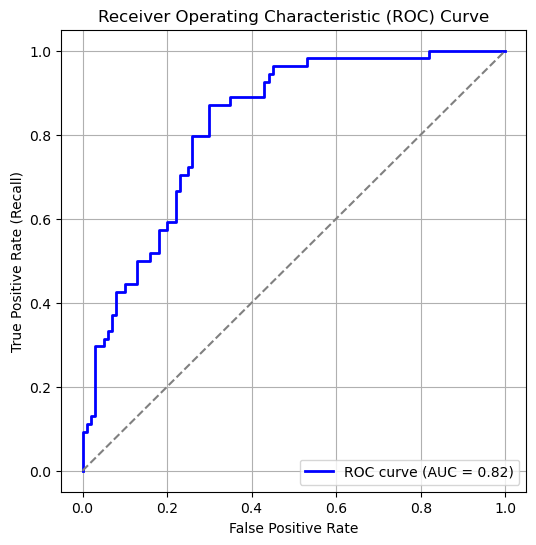

In [16]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_proba = lr.predict_proba(X_test_scaled)[:,1] # = probability of the positive class

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)


plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

### Logistic Regression

Chosen as an interpretable baseline for binary classification. Class weighting addresses imbalance. Its coefficients give clear insight into risk factors.


### Analysis: ROC Curve for Logistic Regression
- The ROC curve above evaluates the ability of the logistic regression model to distinguish between diabetic and non-diabetic patients across all possible probability thresholds.

##### AUC (Area Under the Curve): 0.82
- This value indicates the model has strong discriminative power.
In practical terms, there is an 82% chance the model will assign a higher probability to a randomly chosen diabetic patient than to a non-diabetic one.

##### Curve Shape:
- The ROC curve bows well above the diagonal (random guess), approaching the top-left corner. This means the model is effective at achieving a high true positive rate (recall) while keeping the false positive rate low.

##### Interpretation:
- The model successfully identifies diabetic cases with good sensitivity, without producing too many false alarms. This performance is suitable for healthcare applications where catching positive cases is important.

### Random forest
- Random Forest is a strong, robust classifier for tabular data and can handle non-linear relationships and feature interactions well.

I chose Random Forest as a second model because it is robust to outliers, can model complex nonlinear relationships, and provides built-in estimates of feature importance. It is less sensitive to feature scaling and often performs well on structured, tabular datasets like this one. Using class weighting, I ensured the model would treat diabetic and non-diabetic cases fairly despite the class imbalance.




In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(class_weight='balanced', random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best ROC-AUC on validation:", grid_search.best_score_)


Best parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best ROC-AUC on validation: 0.8305996111667532


I tuned the most important hyperparameters for Random Forest, including the number of trees, tree depth, and minimum samples per split and leaf. GridSearchCV was used to find the combination that maximized ROC-AUC, helping avoid overfitting while maximizing predictive performance.

In [25]:
from sklearn.ensemble import RandomForestClassifier


# Use the best parameters you found
rf_best = RandomForestClassifier(
    max_depth=5,
    min_samples_leaf=1,
    min_samples_split=10,
    n_estimators=100,
    class_weight='balanced',  
    random_state=42
)

rf_best.fit(X_train_scaled, y_train)

y_pred_rf = rf_best.predict(X_test_scaled)
y_proba_rf = rf_best.predict_proba(X_test_scaled)[:, 1]  


Tree-based models like Random Forest don’t require scaling, but we are using the scaled data for consistent comparison with other models.

In [27]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))



Random Forest Confusion Matrix:
[[77 23]
 [14 40]]

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.77      0.81       100
           1       0.63      0.74      0.68        54

    accuracy                           0.76       154
   macro avg       0.74      0.76      0.75       154
weighted avg       0.77      0.76      0.76       154



The Random Forest classifier achieves a 76% overall accuracy on the test set. It is especially effective at identifying non-diabetic cases (precision = 0.85), but also shows respectable performance for diabetic patients (recall = 0.74, meaning it correctly identifies 74% of diabetics).

The model does, however, produce some false positives (23 non-diabetics predicted as diabetics) and false negatives (14 diabetics missed). This is a common trade-off in imbalanced datasets, but with class weighting, the Random Forest model balances the ability to catch true diabetics (recall for class 1) without too many false alarms.

Key takeaways:

- High recall for diabetics (0.74): Good for a screening tool where catching as many diabetic cases as possible is valuable.

- Lower precision for diabetics (0.63): Some non-diabetic patients are incorrectly flagged, which might be acceptable in a healthcare setting for further testing.

- Balanced performance: F1-scores of 0.81 (No Diabetes) and 0.68 (Diabetes) show the model is useful for both classes.


Random Forest ROC-AUC Score: 0.829


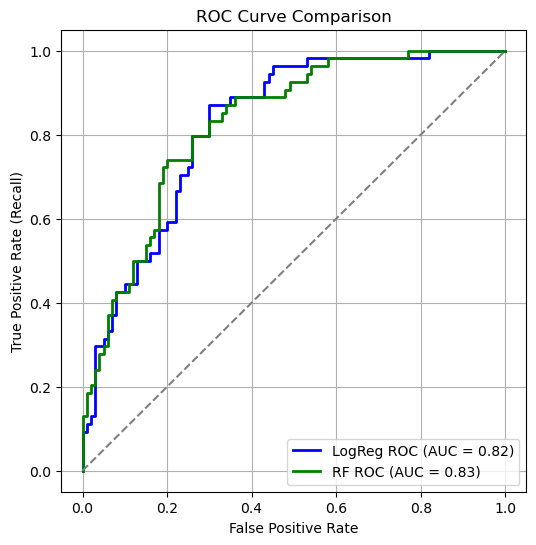

In [29]:
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
print("\nRandom Forest ROC-AUC Score:", round(roc_auc_rf, 3))
y_proba_rf = rf_best.predict_proba(X_test_scaled)[:, 1]  

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'LogReg ROC (AUC = {roc_auc:.2f})')
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'RF ROC (AUC = {roc_auc_rf:.2f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid()
plt.show()


### Random Forest

A robust, non-linear ensemble that often excels with tabular data. Handles interactions and non-linearity, and built-in feature importances provide interpretability.


This strong AUC score, along with solid recall for the diabetic class, demonstrates that the Random Forest model is a robust tool for identifying individuals at risk of diabetes, and could serve as an effective basis for clinical decision support or screening.



### SVM

I included SVM in my model comparison because it is known for its strong performance in high-dimensional settings and its ability to learn complex, nonlinear relationships via kernel methods. The “maximum margin” principle and support for class weighting also make it robust to overfitting and class imbalance, which are both relevant to this healthcare dataset.

In [35]:
from sklearn.svm import SVC

# SVC = Support Vector Classifier
# Use 'probability=True' to enable probability outputs for ROC/AUC
svm = SVC(C = 1, gamma = 0.1, class_weight='balanced', probability=True, random_state=42)
svm.fit(X_train_scaled, y_train)

y_pred_svm = svm.predict(X_test_scaled)
y_proba_svm = svm.predict_proba(X_test_scaled)[:, 1]  # For ROC/AUC, use positive class probability



In [36]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

print("SVM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))

print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred_svm))


SVM Confusion Matrix:
[[68 32]
 [13 41]]

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.68      0.75       100
           1       0.56      0.76      0.65        54

    accuracy                           0.71       154
   macro avg       0.70      0.72      0.70       154
weighted avg       0.74      0.71      0.71       154



### Support Vector Machine (SVM)

Effective for high-dimensional and non-linear problems. With kernel tuning and class weighting, SVM can maximize recall for diabetics—a valuable trait in medical screening.
#### Insights

The SVM classifier achieves a 71% overall accuracy on the test set. The model demonstrates a strong recall for diabetic cases (0.76), correctly identifying 76% of patients with diabetes. This is especially valuable in medical settings, where missing diabetic cases could have serious consequences.

However, the SVM also produces more false positives than the other models (32 non-diabetics predicted as diabetics), leading to a lower precision for the diabetic class (0.56). In practical terms, this means more healthy patients might be flagged for further testing—an acceptable trade-off if the main goal is to catch as many true diabetics as possible.

Summary:

- High recall for diabetics: Most real cases are detected.

- Lower precision for diabetics: More false alarms.

- Trade-off: SVM is tuned for sensitivity (catching positives) at the expense of some specificity (avoiding false positives).

- In contexts where it’s critical not to miss cases (such as health screening), this SVM model could be useful—though it may increase the workload for follow-up testing.





SVM ROC-AUC Score: 0.801


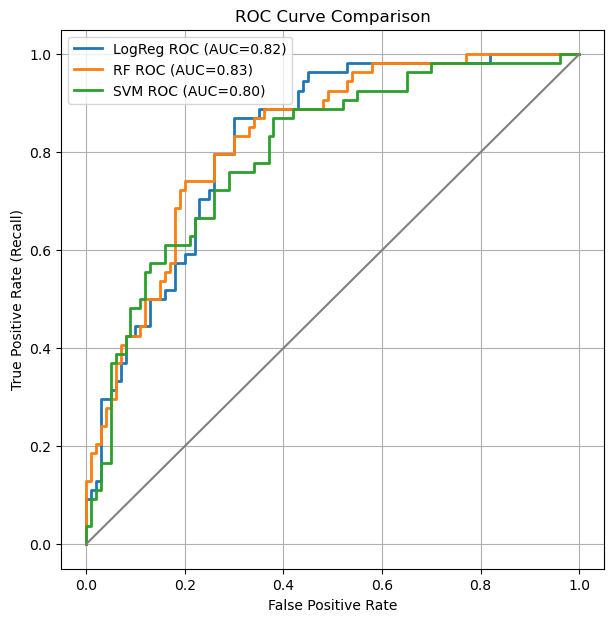

In [51]:

roc_auc_svm = roc_auc_score(y_test, y_proba_svm)
print("\nSVM ROC-AUC Score:", round(roc_auc_svm, 3))

fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)

plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, label=f'LogReg ROC (AUC={roc_auc:.2f})', lw=2)
plt.plot(fpr_rf, tpr_rf, label=f'RF ROC (AUC={roc_auc_rf:.2f})', lw=2)
plt.plot(fpr_svm, tpr_svm, label=f'SVM ROC (AUC={roc_auc_svm:.2f})', lw=2)
plt.plot([0,1], [0,1], color='gray', linestyle='solid')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid()
plt.show()


In [57]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Logistic Regression
acc_lr = accuracy_score(y_test, y_pred)
prec_lr = precision_score(y_test, y_pred)
recall_lr = recall_score(y_test, y_pred)
f1_lr = f1_score(y_test, y_pred)
auc_lr = roc_auc_score(y_test, y_proba)

# Random Forest
acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_proba_rf)

# SVM
acc_svm = accuracy_score(y_test, y_pred_svm)
prec_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
auc_svm = roc_auc_score(y_test, y_proba_svm)


## Conclusion

### Summary Table: Test Set Performance


In [60]:
print("| Model                | Accuracy | Precision (Diab) | Recall (Diab) | F1 (Diab) | ROC-AUC |")
print("|----------------------|----------|------------------|---------------|-----------|---------|")
print(f"| Logistic Regression  | {acc_lr:.2f}     | {prec_lr:.2f}             | {recall_lr:.2f}          | {f1_lr:.2f}      | {auc_lr:.2f}    |")
print(f"| Random Forest        | {acc_rf:.2f}     | {prec_rf:.2f}             | {recall_rf:.2f}          | {f1_rf:.2f}      | {auc_rf:.2f}    |")
print(f"| SVM                  | {acc_svm:.2f}     | {prec_svm:.2f}             | {recall_svm:.2f}          | {f1_svm:.2f}      | {auc_svm:.2f}    |")


| Model                | Accuracy | Precision (Diab) | Recall (Diab) | F1 (Diab) | ROC-AUC |
|----------------------|----------|------------------|---------------|-----------|---------|
| Logistic Regression  | 0.73     | 0.60             | 0.70          | 0.65      | 0.82    |
| Random Forest        | 0.76     | 0.63             | 0.74          | 0.68      | 0.83    |
| SVM                  | 0.71     | 0.56             | 0.76          | 0.65      | 0.80    |




> **Insights:**  
> - **Random Forest** provides the best overall balance and ROC-AUC, making it a strong candidate for deployment.  
> - **SVM** achieves the highest recall for diabetics, crucial in healthcare screening where false negatives can be dangerous.  
> - **Logistic Regression** is highly interpretable and competitive, a great baseline and a strong choice for explainability.

**Business Impact:**  
This workflow demonstrates the full process from data exploration to actionable model deployment. Choosing a model for healthcare means balancing recall, precision, and practical considerations like interpretability.

**Next Steps:**  
- Consider deeper feature engineering, additional external datasets, or ensemble methods for further gains.
- Deploy the best model in a dashboard or web app for maximum impact.

---

**Thank you for reading!**


In [66]:
# Export predictions for each model
results_df = X_test.copy()
results_df['Actual'] = y_test.values
results_df['LogReg_Pred'] = y_pred
results_df['LogReg_Prob'] = y_proba
results_df['RF_Pred'] = y_pred_rf
results_df['SVM_Pred'] = y_pred_svm
results_df.to_csv('model_predictions.csv', index=False)

# Export model metrics
import pandas as pd
metrics = {
    'Model': ['Logistic Regression', 'Random Forest', 'SVM'],
    'Accuracy': [acc_lr, acc_rf, acc_svm],
    'Precision_Diabetes': [prec_lr, prec_rf, prec_svm],
    'Recall_Diabetes': [recall_lr, recall_rf, recall_svm],
    'F1_Diabetes': [f1_lr, f1_rf, f1_svm],
    'ROC_AUC': [auc_lr, auc_rf, auc_svm]
}
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv('model_metrics.csv', index=False)

df.to_csv('diabetes_cleaned.csv', index=False)
